# 1. Initializations and Dataset Download
In this cell, we will install the opendatasets library which will allow us to download the data from kaggle directly by just providing the dataset link and we will also download the dataset from kaggle [here](https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification)

In [2]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: omaratef3221
Your Kaggle Key: ··········


100%|██████████| 155M/155M [00:02<00:00, 76.4MB/s]


# 2. Imports
Lets start by getting all our imports. Additionally, we will check if TensorFlow is using the GPU or not. If everything is installed correctly, TensorFlow will use the GPU automatically and in Colab everything is installed for you.

In [3]:
import tensorflow as tf # TensorFlow main library
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Main image data generator to read the images
from tensorflow.keras import models, layers, Sequential # Models layer e.g. Dense, Convolutions, etc.
from tensorflow.keras.applications.vgg16 import VGG16 # Import the pretrained model
import matplotlib.pyplot as plt # Plotting to plot train progress
from sklearn.metrics import classification_report # For Evaluation
import pandas as pd # Pandas for data analysis
import numpy as np # Analysis for numbers
import os # Interacting with the operating system

print(tf.config.list_physical_devices('GPU')) # Checking if tensorflow is using the GPU

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 3. Reading Data Paths
Luckily our dataset is already organized well in two folders which are having the CSV files that has the images directories for both training and validation. We will read these CSVs and we will merge them both in order to split again the data with our own split percentage. After reading the files. We will use the `concat` function to merge these two CSVs and then we will modify the path to make sure it includes the full path in colab. Then we will print the data shape `(rows, columns)` and then we will use the `head` function to print the first 5 rows only.

In [4]:
train_df = pd.read_csv("/content/bean-leaf-lesions-classification/train.csv")
val_df = pd.read_csv("/content/bean-leaf-lesions-classification/val.csv")

data_df = pd.concat([train_df, val_df], ignore_index=True)

data_df["image:FILE"] = "/content/bean-leaf-lesions-classification/" + data_df["image:FILE"]

print("Data shape is: ", data_df.shape)
print()
data_df.head()

Data shape is:  (1167, 2)



,image:FILE,category
0,/content/bean-leaf-lesions-classification/trai...,0
1,/content/bean-leaf-lesions-classification/trai...,0
2,/content/bean-leaf-lesions-classification/trai...,0
3,/content/bean-leaf-lesions-classification/trai...,0
4,/content/bean-leaf-lesions-classification/trai...,0


# 4. Data Analysis
Now we will do an optional part. But its always recommended to check the details of your data. In the cell below we will see our classes which are 0,1,2 which means its a multi class classification problem. Additionally we will see the classes distribution and its clearly shows that data is almost balanced completely.

In [5]:
print("Classes are: ")
print(data_df["category"].unique())
print()
print("Classes ditrubution are: ")
print(data_df["category"].value_counts())

Classes are: 
[0 1 2]

Classes ditrubution are: 
2    393
1    389
0    385
Name: category, dtype: int64


# 5. Data Split
Now lets split the dataset into training and testing. Since data is very small, no need to do a validation split. We will split the data same way we did in the previous exercise. We will do that by getting a random sample of 70% from our data using `data_df.sample(frac=0.7,random_state=7)` then we will create a new variable of `test` dataset which we will drop from it the 70% of the `train` which means that it will be 30% of the data which is the rest of the data using `data_df.drop(train.index)`.

In [6]:
train=data_df.sample(frac=0.7,random_state=7) # Create training of 70% of the data
test=data_df.drop(train.index) # Create testing by removing the 70% of the train data which will result in 30%

# 6. Data preprocessing


In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize the images
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

batch_size = 16  # Adjust based on your RAM capacity

train_generator = train_datagen.flow_from_dataframe(
    train,
    x_col='image:FILE',
    y_col='category',
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='raw'  # Use 'binary' for binary classification
)

test_generator = test_datagen.flow_from_dataframe(
    test,
    x_col='image:FILE',
    y_col='category',
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='raw'  # Use 'binary' for binary classification
)

Found 817 validated image filenames.
Found 350 validated image filenames.


# 7. Base Model

In [8]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False ## Not trainable weights

58889256/58889256 [==============================] - 0s 0us/step


# 8. Modified Model

In [9]:
model = Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(64, activation = "relu"),
    layers.Dense(32, activation = "relu"),
    layers.Dense(3, activation = "softmax")
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 64)                524352    
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 15241219 (58.14 MB)
Trainable params: 526531 (2.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


# 9. Compiling and Training


In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_generator, epochs=10,)

Epoch 1/10
52/52 [==============================] - 12s 125ms/step - loss: 0.9294 - accuracy: 0.5337
Epoch 2/10
52/52 [==============================] - 4s 77ms/step - loss: 0.6239 - accuracy: 0.7540
Epoch 3/10
52/52 [==============================] - 3s 61ms/step - loss: 0.4861 - accuracy: 0.8127
Epoch 4/10
52/52 [==============================] - 4s 82ms/step - loss: 0.3874 - accuracy: 0.8666
Epoch 5/10
52/52 [==============================] - 3s 63ms/step - loss: 0.3277 - accuracy: 0.9009
Epoch 6/10
52/52 [==============================] - 3s 62ms/step - loss: 0.2652 - accuracy: 0.9388
Epoch 7/10
52/52 [==============================] - 4s 73ms/step - loss: 0.2297 - accuracy: 0.9523
Epoch 8/10
52/52 [==============================] - 3s 61ms/step - loss: 0.1957 - accuracy: 0.9608
Epoch 9/10
52/52 [==============================] - 4s 69ms/step - loss: 0.1626 - accuracy: 0.9755
Epoch 10/10
52/52 [==============================] - 4s 81ms/step - loss: 0.1346 - accuracy: 0.9853


# 10. Testing

In [11]:
test_results = model.evaluate(test_generator)
print()
for indx, metric in enumerate(model.metrics_names):
  print("Testing ",metric, ": ", round(test_results[indx], 4))

22/22 [==============================] - 4s 158ms/step - loss: 0.4892 - accuracy: 0.8029

Testing  loss :  0.4892
Testing  accuracy :  0.8029



# 11. Plotting Training Progress
Let's plot the training loss and accuracy progress through out the EPOCHS using the history variable we created before and assigned to it the training progress. The results may not be very good, feel free to play with the layers, hyperparameters and text filteration to achieve better performance!

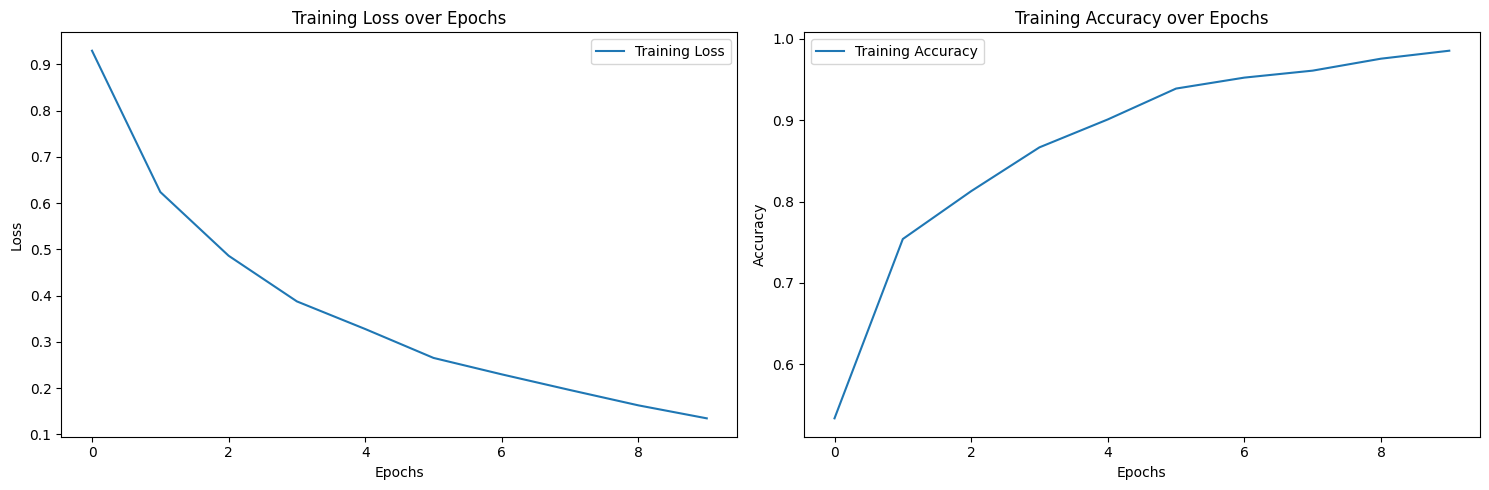

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(history.history['loss'], label='Training Loss')
# axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(history.history['accuracy'], label='Training Accuracy')
# axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Training Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()